In [ ]:
# Github: https://github.com/ttarter3/CPE490590hw05.git
# Colab Part 1: https://colab.research.google.com/drive/1Kf1rvav7WuNVUuEyA57mn-huQFFvE6Cj?usp=sharing

!pip install torch torchvision
!pip install onnx onnxruntime onnxscript

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import onnx
import onnxruntime

import os, sys
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
output_model = 'mnist.onnx'

device = 'cpu'
if torch.cuda.is_available():
    device = torch.device("cuda:0")

    properties = torch.cuda.get_device_properties(device)
    print(f"Device Name: {properties.name}")
    print(f"Total Memory: {properties.total_memory / 1e9:.2f} GB")
    print(f"Compute Capability: {properties.major}.{properties.minor}")
    print(f"Multi-processors: {properties.multi_processor_count}")

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

Device Name: Tesla T4
Total Memory: 15.83 GB
Compute Capability: 7.5
Multi-processors: 40


In [ ]:
full_dataset = torchvision.datasets.MNIST(root='./data', transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.00MB/s]



# q1.1.1

In [ ]:
for ii in range(len(full_dataset)):
    if full_dataset[ii][0].dtype != torch.float32:
        full_dataset[ii][0] = full_dataset[ii][0].float() / 255.0
    assert(0 <= torch.min(full_dataset[ii][0]) and torch.max(full_dataset[ii][0]) <= 1)


# q1.1.2

In [ ]:
test_cnt = int(len(full_dataset) / 3)
train_cnt = int(len(full_dataset) - test_cnt)
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_cnt, test_cnt])

# q1.1.3

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        self.fc1    = torch.nn.Linear(1600, 128)
        self.relu3  = torch.nn.ReLU()

        self.drop   = torch.nn.Dropout(p=0.5)
        self.fc2    = torch.nn.Linear(128, 10)
        self.smax   = torch.nn.Softmax(dim=0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = torch.flatten(x)
        x = self.fc1  (x)
        x = self.relu3(x)
        x = self.drop (x)
        x = self.fc2  (x)
        x = self.smax (x)
        return x

model = CNN().to(device)

# q1.1.4

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# q1.1.5

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Outer loop: 100%|██████████| 50/50 [1:32:16<00:00, 110.72s/it]


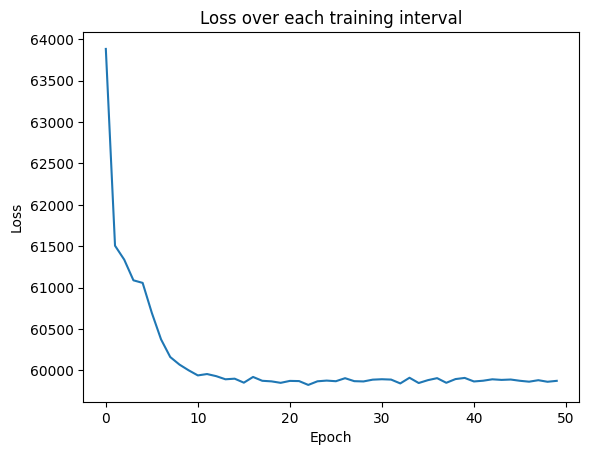

In [ ]:
N = 50
cum_loss = np.zeros(N)
for epoch in tqdm(range(N), desc="Outer loop"):
    # for idx in tqdm(range(len(train_dataset)), desc="Inner Loop", leave=False):
    for idx in range(len(train_dataset)):

        [images, labels] = train_dataset[idx]

        stat = torch.zeros(10)
        stat[labels] = 1
        images =  images.to(device)
        labels = stat.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        cum_loss[epoch] += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()

plt.figure()
plt.plot(cum_loss)
plt.title("Loss over each training interval")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("LossFunction.png")
plt.show()

# q1.1.6

/usr/local/lib/python3.11/dist-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/usr/local/lib/python3.11/dist-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


[torch.onnx] Obtain model graph for `CNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `CNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


<ipython-input-12-1c239fbf1045>:24: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.tight_layout()
<ipython-input-12-1c239fbf1045>:25: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig("ExpectedvsPredicted.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


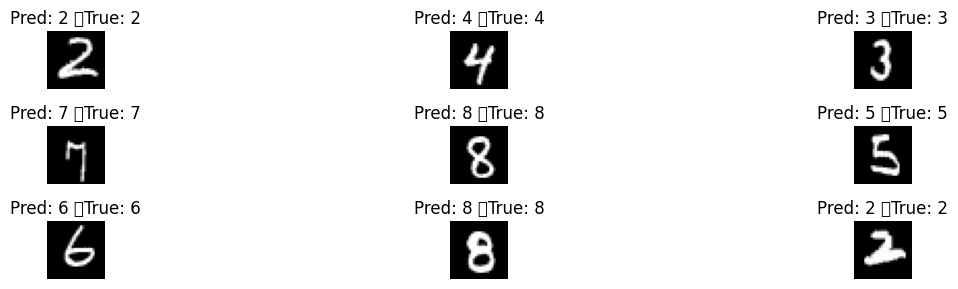

In [ ]:
model.eval()
import onnxscript
onnx_program = torch.onnx.export(model, train_dataset[0][0].to(device), dynamo=True)
onnx_program.optimize()
onnx_program.save(output_model)

samples = 9
indices = np.random.choice(len(test_dataset), samples, replace=False)
fig, axes = plt.subplots(int(np.sqrt(samples)), int(np.sqrt(samples)), figsize=(15, 3))
for i in range(samples):
    row = int (i / np.sqrt(samples))
    col = int(np.mod(i, int(np.sqrt(samples))))

    labels = test_dataset[indices[i]][1]
    with torch.no_grad():
        images = test_dataset[indices[i]][0].to(device)
        outputs = model(images)
        predicted_labels = torch.argmax(outputs)

    ax = axes[row, col]
    ax.imshow(images.cpu().numpy().squeeze(), cmap='gray')
    ax.set_title(f"Pred: {predicted_labels.item()} \tTrue: {labels}")
    ax.axis('off')
fig.tight_layout()
plt.savefig("ExpectedvsPredicted.png")
plt.show()

# q1.1.7

In [ ]:
onnx_model = onnx.load(output_model)
onnx.checker.check_model(onnx_model)

<ipython-input-14-5740bf01e093>:20: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.tight_layout()
<ipython-input-14-5740bf01e093>:21: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig("ONNXExpectedvsPredicted.png")


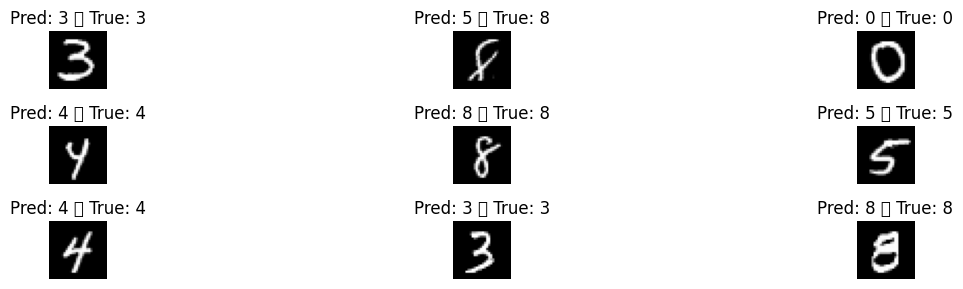

In [ ]:
# q1.1.7
session = onnxruntime.InferenceSession(output_model)
samples = 9
indices = np.random.choice(len(test_dataset), samples, replace=False)

fig, axes = plt.subplots(int(np.sqrt(samples)), int(np.sqrt(samples)), figsize=(15, 3))
for i in range(samples):
    row = int (i / np.sqrt(samples))
    col = int(np.mod(i, int(np.sqrt(samples))))

    labels = test_dataset[indices[i]][1]
    images = test_dataset[indices[i]][0]
    output = session.run(None, {session.get_inputs()[0].name: images.numpy()})
    predicted_labels = np.argmax(output)

    ax = axes[row, col]
    ax.imshow(images[0, :, :].squeeze(), cmap='gray')
    ax.set_title(f"Pred: {predicted_labels} \t True: {labels}")
    ax.axis('off')
fig.tight_layout()
plt.savefig("ONNXExpectedvsPredicted.png")
plt.show()